In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Imports

In [2]:
# from sklearnex import patch_sklearn
# patch_sklearn()

from psutil._common import bytes2human
import time
import sys
import numpy as np
import scipy as sp
import torch as tc
# import skdim
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mutual_info_score
from hummingbird.ml import convert
from scipy.integrate import solve_ivp, odeint
import scipy.signal as signal
import scipy as sp
# import pypsr as pyps
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib import rc
%matplotlib inline

from numba import jit

np.set_printoptions(linewidth=250)

font_dir = 'C:/Users/AdamG/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/'
# font_dir = '/Users/adamgiammarese/Library/Fonts/'

# Set Directories

In [3]:
base_dir = os.getcwd().replace('\\','/') + '/'
fig_dir = base_dir + 'Figures/Lorenz Attractor/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

data_dir = base_dir + 'Lorenz_Data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

os.chdir(base_dir)

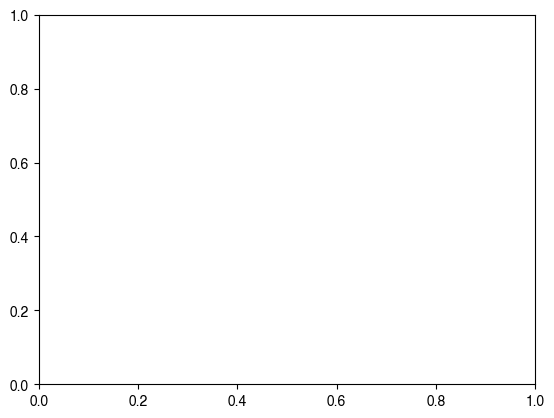

In [4]:
# !cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}\makeatletter \newcommand{\roml}[1]{\lowercase\expandafter{\romannumeral #1\relax}}\newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother')

plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper Functions

In [5]:
def lorenz(X,t,sigma=10,beta=8/3,rho=28):
    x, y, z = X
    dx = sigma*(y-x)
    dy = x*(rho-z) - y
    dz = x*y - beta*z
    return [dx, dy, dz]

def evolve(f,Tmax,dt,x0,sigma=10,beta=8/3,rho=28):
    t = np.arange(0,Tmax,dt)
    result = odeint(f, x0, t, args=(sigma,beta,rho))
    x,y,z = result.T
    return x,y,z,t

def lead_data(data,stride=1,lead=1):
    n_samples = len(data) - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j,:].flatten()
        labels[i,:] = data[j+lead,:].flatten()
    return features, labels

def AMI(x1, x2, bins=10):
    if len(np.shape(x1)) == 2 and np.shape(x1)[1] == 1:
        x1 = np.array(x1).reshape(-1,)
    if len(np.shape(x2)) == 2 and np.shape(x2)[1] == 1:
        x2 = np.array(x2).reshape(-1,)
    return mutual_info_score(None, None, contingency=np.histogram2d(x1, x2, bins=10)[0])

def lagged_AMI(x, max_lag=None, bins=10, normalize=True):
    if max_lag is None:
        max_lag = len(x)//2
    if len(np.shape(x)) == 1:
        return np.array([AMI(x[:len(x)-tau], x[tau:], bins=bins) for tau in range(max_lag)]).reshape(-1,1)
    else:
        return np.array([np.array([AMI(x[:len(x)-tau,i], x[tau:,i], bins=bins)
                          for tau in range(max_lag)])/AMI(x[:,i],x[:,i], bins=bins) for i in range(x.shape[1])]).T

def get_tau_crits(X_train, p_val=0.05, max_lag=600, bins=10, make_plot=False, 
                  dim_labels=['x','y','z'], save_fig=False, fname='',
                  title=None, debug_data=False, peak_order=1,
                  incorporate_peaks=True):
    amis = []
    N = X_train.shape[1]
    
    if dim_labels is None:
        dim_labels = np.arange(N).astype(str)
    
    max_lag = len(X_train)//2 if max_lag is None else min(max_lag,len(X_train)//2)
    lags = np.arange(max_lag)
    amis = lagged_AMI(X_train, max_lag, bins=bins, normalize=True)

#     for i in range(N):
#         lags, ami = pyps.lagged_ami(X_train[:,i], max_lag=max_lag)
#         amis.append(ami)
#     amis = np.array(amis).T
    
#     for i in range(N):
#         amis[:,i] /= amis[0,i]
        
    quantiles = np.quantile(amis, p_val, axis=0)
    
    drop_below_quantile = []
    peaks = []
    for i in range(N):
        peaks.append(sp.signal.argrelextrema(amis[:,i], np.greater, order=peak_order)[0])
        drop_below_quantile.append([])
        for j in range(1,max_lag):
            if amis[j,i] < quantiles[i] and amis[j-1,i] > quantiles[i]:
                drop_below_quantile[i].append(j)
        
    tau_crits = []
    for i in range(N):
        if incorporate_peaks:
            tau_crits.append(drop_below_quantile[i][0] if drop_below_quantile[i][0] > peaks[i][0] else (2*peaks[i][0] if peaks[i][0]<max_lag/2 else peaks[i][0]))
        else:
            tau_crits.append(drop_below_quantile[i][0])
#         tau_crits.append(2*drop_below_quantile[i][0] if drop_below_quantile[i][0] < max_lag/2 else drop_below_quantile[i][0])
#         tau_crits.append(drop_below_quantile[i][min(2,len(drop_below_quantile[i])-1)])
#         for j in range(max_lag):
#             if amis[j,i] <= quantiles[i]:#p_val:
#                 break
#         tau_crits += [j-1]
        
    if make_plot:
        fontsize = 32
        ms = 5
        lw = 2
        
        yticks = [0, 0.5, 1]


        ylim = [0,1]
        xy_annotate = (0.01,0.95)

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)
        
        fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True)
        axs_lst = [axs] if N==1 else axs
        
        if title is not None:
            axs[0].set_title(title, fontsize=fontsize)
        
        for i, ax in enumerate(axs_lst):
            ax.plot(lags,amis[:,i],'k',lw=lw)
            
#             ax.axhline(p_val, ls='--', lw=lw, c='r')
            ax.axvline(tau_crits[i], ls='--', lw=lw, c='r')
            
            ax.axhline(quantiles[i], ls=':', lw=lw, c='b')
            ax.axvline(drop_below_quantile[i][0], ls=':', lw=lw, c='b')
            
            ax.set_xlim(0, max_lag-1)
            ax.set_ylim(ylim)
#             ax.text(0.99*max_lag, p_val+0.01, f'$pval={p_val}$', fontsize=fontsize, va='bottom', ha='right',
#                     color='r')
            if tau_crits[i] >= max_lag/2:
                ax.text(tau_crits[i]-0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='right', color='r')
            else:
                ax.text(tau_crits[i]+0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='left', color='r')
            
            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xticks = ax.get_xticks()
            if max_lag != xticks[-1]:
                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                xticks = ax.get_xticks()[:-1]
            ax.set_xticks(xticks)
            ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
            
            
            ax.plot(peaks[i],amis[peaks[i],i],'ro',ms=ms,label='Peaks')
            ax.set_ylabel(r'$AMI_{'+f'{dim_labels[i]}'+r'}(\tau)$', fontsize=fontsize)
            # ax1.legend(loc='upper right',prop={'size': 24})
            ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
#             ax.set_xticks(xticks)
            # ax1.set_xticklabels(xticks, fontsize=fontsize)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize)
    
            if i == N - 1:
                ax.set_xlabel(r'$\tau$', fontsize=fontsize)
                
            plt.setp(ax.spines.values(), linewidth=2, zorder=100)
            ax.tick_params(length=10,width=2)
            
            ax.set_zorder(N-i)
    
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.2,wspace=0.15)
        fig.align_labels(axs)
        
        if save_fig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

        plt.show()
    
    if debug_data:
        return tau_crits, amis, peaks
    else:
        return tau_crits    

def make_features_and_labels(data,k,xi=1,stride=1,lead=1):
    n_samples = len(data) - (k-1)*xi - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,k*n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j:j+k*xi:xi,:].T.flatten()
        labels[i,:] = data[j+(k-1)*xi+lead,:].flatten()
    return features, labels

def feature_selection(features, labels, n_estimators=100, max_depth=None,
                      random_state=None, n_jobs=-1, n_samples=None,
                      model_type='RFR', verbose=False, return_model=False):
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    start_time = time.time()
    stride = 1 if n_samples is None else len(features)//n_samples
    if model_type == 'RFR':
        Regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          verbose=verbose).fit(features[::stride], labels[::stride])
    else:
        Regressor = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        verbose=verbose).fit(features[::stride], labels[::stride])
    end_time = time.time()
    if verbose:
        print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(Regressor))))
    if return_model:
        return Regressor.feature_importances_, Regressor, end_time-start_time
    else:
        return Regressor.feature_importances_, end_time-start_time

def future_prediction(features=None, labels=None, FIs=None, future=None, p=None, xi=1,
                      n_estimators=200, disp_progress=False, desc='',
                      max_depth=None, random_state=None, n_jobs=-1,
                      min_samples_split=2, min_samples_leaf=1, ccp_alpha=0,
                      max_features=1.0, n_samples=None, model=None, s=None,
                      model_type='ETR', verbose=False, model_conversion=None,
                      device='cuda', debug_plot=False, save_fig=False, fname='',
                      dim_labels=None):
    if labels is None:
        N = np.shape(s)[0]
    else:
        N = np.shape(labels)[1]
    p_original = p
    k = np.shape(FIs)[-1]//N
    if features is not None and np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if labels is not None and np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if len(np.shape(p)) == 1:
        if verbose or disp_progress:
            print(f'Num features selected (given ind): {len(p)} of {len(FIs)}')
        ind = np.array(p)
    else:
        if len(np.shape(FIs)) == 2:
            all_FIs = FIs
            FIs = np.mean(FIs, axis=0)

            pvalue_thresh = 0.05
            pop_mean = 0
            pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
            ind = np.where(pvalues <= pvalue_thresh)[0]
            if len(ind) == 0:
                ind = np.arange(len(FIs))
            FI_0 = np.min(FIs[ind])
            if len(np.where(FIs >= FI_0)[0])/len(FIs) >= 0.5:
                pop_mean = np.median(FIs)
                pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
                ind = np.where(pvalues <= pvalue_thresh)[0]
                if len(ind) == 0:
                    # ind = np.arange(len(FIs))
                    FI_0 = np.median(FIs)
                else:
                    FI_0 = np.min(FIs[ind])
#             ind = np.where(FIs >= FI_0)[0]
#             p = len(np.where(FIs >= FI_0)[0])
        else:
            FI_0 = np.median(FIs)
        p = len(np.where(FIs >= FI_0)[0])#len(np.where(FIs >= np.mean(FIs))[0])
        if p_original is not None:
            if type(p_original) == str:
                p = round(float(p_original)*p)
            elif type(p_original) != int:
                p = round(p_original*len(FIs))
            else:
                if p_original < 0:
                    p = len(FIs)
        p = min(p, len(FIs))
        if verbose or disp_progress:
            print(f'Num features selected (given mean FIs): {p} of {len(FIs)}')
        ind = np.argsort(-FIs)[:p]

        if debug_plot:
            fontsize = 32
            ms = 10
            lw = 2

            if dim_labels is None:
                dim_labels = np.arange(1,N+1).astype(str)
            
            xy_annotate = (0.01,0.95)
            
            plt.rc('text', usetex=True)
            plt.rc('xtick',labelsize=fontsize)
            plt.rc('ytick',labelsize=fontsize)
            
            fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True,sharey=True)
            axs_lst = [axs] if N==1 else axs
            
            lags = np.arange(k)
            
            FI_0 = np.median(FIs)
            
            # ind = np.where(FIs >= FI_0)[0]
            
            for i, ax in enumerate(axs_lst):
                ax.plot(lags,FIs[i*k:(i+1)*k][::-1],'k',lw=lw)
            #     where = np.where(FIs[i*k-1:(i-1)*k:-1] >= np.median(FIs))[0]
            #     where = np.where(pvalues[i*k-1:(i-1)*k:-1] >= pvalue_thresh)[0]
            #     ax.plot(lags[where], FIs[i*k-1:(i-1)*k:-1][where], 'b.', ms=10, zorder=10)
            
            #     ind_tmp = np.where(FIs[i*k:(i+1)*k] >= FI_0)[0]
                
                
                ind_tmp = ind[np.where(np.logical_and(ind <= (i+1)*k-1, ind >= i*k))[0]]
                
            # #     pvalues_tmp = pvalues[i*k:(i+1)*k]
            # #     where = np.where(pvalues_tmp >= pvalue_thresh)[0]
            # #     if len(where) == 0:
            # #         ind_tmp = np.arange(k)[np.argmax(pvalues_tmp):]
            # #     else:
            # #         ind_tmp = np.arange(k)[where[-1]:]
            
                ax.plot((i+1)*k-1-ind_tmp,FIs[ind_tmp],'b.',ms=10)
                
                ax.axhline(FI_0, ls='--', c='r', lw=lw)
            
                ax.set_xlim(0, max(lags))# k-1)
                ax.set_ylim(0, None)
                
                xticks = ax.get_xticks()
                ax.set_xticks(xticks)
                ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
                
                ax.text(0.99*ax.get_xlim()[1], FI_0+0.05*np.diff(ax.get_ylim()), r'$\text{median}(\mathbf{FI})$', fontsize=fontsize, va='bottom', ha='right',
                        color='r')
            
                ax.set_ylabel(r'$FI_{'+'{:}'.format(dim_labels[i])+r'}(\tau)$', fontsize=fontsize)
                # ax1.legend(loc='upper right',prop={'size': 24})
                if N > 26:
                    ax.annotate(r'\textbf{(\roml{'+str(i+1)+'})}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
                else:
                    ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
            #             ax.set_xticks(xticks)
                yticks = ax.get_yticks()
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=fontsize)
            
                if i == N - 1:
                    ax.set_xlabel(r'$\tau$', fontsize=fontsize)
            
                plt.setp(ax.spines.values(), linewidth=2, zorder=100)
                ax.tick_params(length=10,width=2)
            
                ax.set_zorder(N-i)
            
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.2,wspace=0.15)
            fig.align_labels(axs)
            
            if save_fig:
                plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
                plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
            
            plt.show()


    
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
            #         elif model_type == 'GBR':
            #             model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, verbose=True)
            #         elif model_type == 'HGBR':
            #             model = HistGradientBoostingRegressor(max_iter=n_estimators, random_state=random_state, verbose=True)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
    if model_conversion == 'hummingbird':
        start_convert = time.time()
        model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
        model.to(device)
        end_convert = time.time()
        if verbose or disp_progress:
            print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
            
            
    prediction = np.zeros((future,N))
    if s is None:
        s = np.hstack((features[-1].reshape((N,k*xi))[:,1:],labels[-1].reshape(-1,1)))#features[-1].reshape((N,k*xi)) # shape (N, k*xi)
    else:
        s = s.reshape((N,k*xi)) # shape (N, k*xi)
    s_delayed = s[:,-(k-1)*xi-1::xi] # shape (N, k)

    if disp_progress:
        lst = trange(future,desc=desc)
    else:
        lst = range(future)
    for i in lst:
        y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
        prediction[i,:] = y_pred.reshape(-1,)
        s = np.hstack((s.reshape((N,k*xi))[:,1:],y_pred))
        s_delayed = s[:,-(k-1)*xi-1::xi]
    prediction = np.array(prediction)
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def future_prediction_lead(features, labels, FIs, future, lead=1, p=None, xi=1, n_estimators=200,
                           disp_progress=False, desc='', leave=False, max_depth=None, random_state=None,
                           n_jobs=-1, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0, max_features=1.0,
                           n_samples=None, model=None, y_train=None, y_test=None, model_type='RFR', verbose=False,
                           open_loop=True, model_conversion=None, device='cuda', debug_plot=False, save_fig=False, fname='',
                           dim_labels=None):
    N = np.shape(labels)[1]
    p_original = p
    k = np.shape(FIs)[-1]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if len(np.shape(p)) == 1:
        if verbose or disp_progress:
            print(f'Num features selected (given ind): {len(p)} of {len(FIs)}')
        ind = np.array(p)
    else:
        if len(np.shape(FIs)) == 2:
            all_FIs = FIs
            FIs = np.mean(FIs, axis=0)

            pvalue_thresh = 0.05
            pop_mean = 0
            pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
            ind = np.where(pvalues <= pvalue_thresh)[0]
            if len(ind) == 0:
                ind = np.arange(len(FIs))
            FI_0 = np.min(FIs[ind])
            if len(np.where(FIs >= FI_0)[0])/len(FIs) >= 0.5:
                pop_mean = np.median(FIs)
                pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
                ind = np.where(pvalues <= pvalue_thresh)[0]
                if len(ind) == 0:
                    # ind = np.arange(len(FIs))
                    FI_0 = np.median(FIs)
                else:
                    FI_0 = np.min(FIs[ind])
#             ind = np.where(FIs >= FI_0)[0]
#             p = len(np.where(FIs >= FI_0)[0])
        else:
            FI_0 = np.median(FIs)
        p = len(np.where(FIs >= FI_0)[0])#len(np.where(FIs >= np.mean(FIs))[0])
        if p_original is not None:
            if type(p_original) == str:
                p = round(float(p_original)*p)
            elif type(p_original) != int:
                p = round(p_original*len(FIs))
            else:
                if p_original <= 0:
                    p = len(FIs)
        p = min(p, len(FIs))
        if verbose or disp_progress:
            print(f'Num features selected (given mean FIs): {p} of {len(FIs)}')
        ind = np.argsort(-FIs)[:p]

        if debug_plot:
            fontsize = 32
            ms = 10
            lw = 2

            if dim_labels is None:
                dim_labels = np.arange(1,N+1).astype(str)
            
            xy_annotate = (0.01,0.95)
            
            plt.rc('text', usetex=True)
            plt.rc('xtick',labelsize=fontsize)
            plt.rc('ytick',labelsize=fontsize)
            
            fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True,sharey=True)
            axs_lst = [axs] if N==1 else axs
            
            lags = np.arange(k)
            
            FI_0 = np.median(FIs)
            
            # ind = np.where(FIs >= FI_0)[0]
            
            for i, ax in enumerate(axs_lst):
                ax.plot(lags,FIs[i*k:(i+1)*k][::-1],'k',lw=lw)
            #     where = np.where(FIs[i*k-1:(i-1)*k:-1] >= np.median(FIs))[0]
            #     where = np.where(pvalues[i*k-1:(i-1)*k:-1] >= pvalue_thresh)[0]
            #     ax.plot(lags[where], FIs[i*k-1:(i-1)*k:-1][where], 'b.', ms=10, zorder=10)
            
            #     ind_tmp = np.where(FIs[i*k:(i+1)*k] >= FI_0)[0]
                
                
                ind_tmp = ind[np.where(np.logical_and(ind <= (i+1)*k-1, ind >= i*k))[0]]
                
            # #     pvalues_tmp = pvalues[i*k:(i+1)*k]
            # #     where = np.where(pvalues_tmp >= pvalue_thresh)[0]
            # #     if len(where) == 0:
            # #         ind_tmp = np.arange(k)[np.argmax(pvalues_tmp):]
            # #     else:
            # #         ind_tmp = np.arange(k)[where[-1]:]
            
                ax.plot((i+1)*k-1-ind_tmp,FIs[ind_tmp],'b.',ms=10)
                
                ax.axhline(FI_0, ls='--', c='r', lw=lw)
            
                ax.set_xlim(0, max(lags))# k-1)
                ax.set_ylim(0, None)
                
                xticks = ax.get_xticks()
                ax.set_xticks(xticks)
                ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
                
                ax.text(0.99*ax.get_xlim()[1], FI_0+0.05*np.diff(ax.get_ylim()), r'$\text{median}(\mathbf{FI})$', fontsize=fontsize, va='bottom', ha='right',
                        color='r')
            
                ax.set_ylabel(r'$FI_{'+'{:}'.format(dim_labels[i])+r'}(\tau)$', fontsize=fontsize)
                # ax1.legend(loc='upper right',prop={'size': 24})
                if N > 26:
                    ax.annotate(r'\textbf{(\roml{'+str(i+1)+'})}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
                else:
                    ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
            #             ax.set_xticks(xticks)
                yticks = ax.get_yticks()
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=fontsize)
            
                if i == N - 1:
                    ax.set_xlabel(r'$\tau$', fontsize=fontsize)
            
                plt.setp(ax.spines.values(), linewidth=2, zorder=100)
                ax.tick_params(length=10,width=2)
            
                ax.set_zorder(N-i)
            
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.2,wspace=0.15)
            fig.align_labels(axs)
            
            if save_fig:
                plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
                plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
            
            plt.show()
    
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        end_time = time.time()
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
    
    
    if open_loop:
        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed_open_loop = np.zeros((future,p))
        for i in range(future):
            s_delayed_open_loop[i,:] = s[:,::xi].flatten()[ind]
            if i >= lead - 1:
                s = np.hstack((s[:,1:].flatten(),y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s[:,1:].flatten(),y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            
        prediction = model.predict(s_delayed_open_loop)
    else:
        prediction = np.zeros((future,N))

        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed = s[:,::xi]
        
        if disp_progress:
            lst = trange(future,desc=desc,leave=leave)
        else:
            lst = range(future)
        for i in lst:
            y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
            prediction[i,:] = y_pred
            if i >= lead - 1:
                s = np.hstack((s[:,1:].flatten(),y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s[:,1:].flatten(),y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            s_delayed = s[:,::xi]
            
    prediction = np.array(prediction).reshape(-1,N)
        
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def rmse(x,y,z,x_result,y_result,z_result,cutoff=0,rm_transient=0):
    x_diff_sq = np.power(x[cutoff+rm_transient:] - x_result[cutoff:],2)
    y_diff_sq = np.power(y[cutoff+rm_transient:] - y_result[cutoff:],2)
    z_diff_sq = np.power(z[cutoff+rm_transient:] - z_result[cutoff:],2)
    return np.sqrt((x_diff_sq + y_diff_sq + z_diff_sq)/3)

def rmse_vec(y_test,y_pred):
    return np.sqrt(np.mean(np.vstack([(y_test[:,i]-y_pred[:,i])**2 for i in range(y_test.shape[1])]), axis=0))

def envelope_length(y_test,y_pred,threshold=5):
    error_signal = rmse_vec(y_test,y_pred)
    return np.argmax(error_signal > threshold)

def lyapunov_time(t,LE_max,cutoff=0,rm_transient=0):
    return (t[cutoff+rm_transient:]-t[cutoff+rm_transient])/LE_max

def get_left_bin_edge(val,bin_edges):
    for i in range(len(bin_edges)):
        if bin_edges[i] > val:
            break
    return bin_edges[i-1], i-1

def get_bottom_height(current_rects,hist,index,scaling=1):
    bottom = current_rects[index]
    height = 1#/hist[index]
    return bottom*scaling, height*scaling

def add_rect_to_plot(left,bottom,width,height,color,ax=None,alpha=1,zorder=None):
    if zorder is None:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)#,facecolor=color)
    else:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,zorder=zorder,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)
    if ax is None:
        plt.gca().add_patch(rect)
    else:
        ax.add_patch(rect)

def delay_embedding_multidimensional(data, emb_dim, n=None, tau=1):
    # input is shape (n_dims,n_samples)
    data = np.array(data)
    if n is None:
        n = data.shape[1] - (emb_dim-1)*tau
    embedding = np.zeros((n,emb_dim*len(data)))
    for i in range(n):
        j = i
        embedding[i,:] = data[:,j:j+emb_dim*tau:tau].flatten()
    return embedding

def RMSE_summary(y_pred, y_test):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        res = []
        for i in range(np.shape(y_test)[1]):
            res.append(np.sqrt(np.mean((y_pred[:,i]-y_test[:,i])**2)))
        return np.mean(res)
    return np.sqrt(np.mean((y_pred-y_test)**2))

def PCC_summary(y_pred, y_test):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        res = []
        for i in range(np.shape(y_test)[1]):
            o_dev = y_test[:,i] - np.mean(y_test[:,i])
            p_dev = y_pred[:,i] - np.mean(y_pred[:,i])
            res.append(np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2))))
        return np.mean(res)
    o_dev = y_test - np.mean(y_test)
    p_dev = y_pred - np.mean(y_pred)
    return np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2)))

def AMI_summary(y_pred, y_test, bins=10, normalize=True):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        return np.mean([AMI(y_pred[:,i], y_test[:,i], bins=bins)/(AMI(y_test[:,i], y_test[:,i], bins=bins)
                                                                  if normalize else 1) for i in range(np.shape(y_test)[1])])
    return AMI(y_pred, y_test, bins=bins)/(AMI(y_test, y_test, bins=bins) if normalize else 1)

def get_hausdorff_dimension_data(data, num=40, lims=(0.01, 50), remove_pval=0):
    if lims is None:
        dist_mat = euclidean_distances(data, data)
#         lims = np.min(dist_mat[np.triu_indices(len(dist_mat), 1)]), np.max(dist_mat)
        lims = (np.min(dist_mat[np.nonzero(dist_mat)]),
                min([(np.max(data[:,i])-np.min(data[:,i])) for i in range(data.shape[1])])) #np.max(dist_mat)
        del dist_mat
    lin_lims = np.log(lims)
#     lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0]/2,
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]/2])
    lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0],
                   lin_lims[1]])
#     lims = np.exp([lin_lims[0],
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]])
    return _get_hausdorff_dimension_data(data, num, lims)

# @jit(nopython=False, parallel=True, nogil=False)
def _get_hausdorff_dimension_data(data, num, lims):
    scales = np.geomspace(lims[0], lims[1], num=num)
    ranges = [(np.min(data[:,i]), np.max(data[:,i])) for i in range(data.shape[1])]
    Ns = np.zeros((num))
    for i, scale in enumerate(scales):
#         if data.shape[1] == 2:
#             H = histogram2d(data[:,0], data[:,1], [round((ranges[i][1]-ranges[i][0])/scale) for i in range(2)],
#                             ranges)
#         else:
        H, _ = np.histogramdd(data, bins=[np.arange(ranges[i][0],ranges[i][1],scale) for i in range(data.shape[1])])
        Ns[i] = np.sum(H>0)
        
    return scales[Ns>0], Ns[Ns>0]

def hausdorff_dimension(data, num=40, lims=None, remove_pval=0, mode='highest_r2', param=10,
                        debug_plots=False, debug_data=False,
                        save_fig=False, fname=''):
    scales, Ns = get_hausdorff_dimension_data(data, num, lims, remove_pval)
    scales_log = np.log(scales)
    Ns_log = np.log(Ns)
    
    if mode == 'highest_slope' or mode == 'highest_r2' or mode == 'highest_product':
        def subarrays(n, x):
            return np.fromfunction(lambda i, j: x[i + j], (len(x) - n + 1, n), 
                                   dtype=int)
        
        if type(param) == int:
            min_pts = param
        else:
            min_pts = round(param*num)

        indices = np.arange(len(Ns))
        windows = []
        for i, window_length in enumerate(range(min_pts, len(Ns))):
            windows += subarrays(window_length, indices).tolist()

        slopes, r2_values = np.zeros((len(windows),)), np.zeros((len(windows),))
        for i, window in enumerate(windows):
            slope, _, r_value, _, _ = sp.stats.linregress(scales_log[window], Ns_log[window])
            slopes[i], r2_values[i] = slope, r_value**2
        
        if mode == 'highest_slope':
            i = np.argmax(np.abs(slopes))
        elif mode == 'highest_r2':
            i = np.argmax(r2_values)
        else:
            i = np.argmax(np.abs(slopes)*r2_values)
            
        start_ind, end_ind = windows[i][0], windows[i][-1]
    else:
        thresh = param
        diff2 = np.gradient(np.gradient(np.log(Ns)))

        linear_inds = np.where(np.logical_and(diff2 >= -thresh, diff2 <= thresh))[0]
        jump_inds = np.where(np.diff(linear_inds) > 1)[0]
        jump_inds = np.unique(np.hstack(([0],jump_inds,[len(linear_inds)-1])))
        ind_maxjump = np.argmax(np.diff(jump_inds))
        start_ind, end_ind = jump_inds[ind_maxjump:ind_maxjump+2]
        start_ind += 1
        start_ind, end_ind = linear_inds[[start_ind, end_ind]]
#         jumps = np.where(np.diff(linear_inds) > 1)[0]
#         linear_widths = np.diff(np.hstack(([0],jumps)))
#         start_ind, end_ind = linear_inds[0], np.where(np.diff(linear_inds) > 1)[0][0]
    

    coeffs = np.polyfit(scales_log[start_ind:end_ind],
                        Ns_log[start_ind:end_ind],deg=1)
    poly = np.poly1d(coeffs)
    yfit = np.exp(poly(scales_log[start_ind:end_ind]))


    if debug_plots:
        fontsize = 24
        lw = 2

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)


        fig, axs = plt.subplots(2,1,figsize=(10,12),height_ratios=(1,2))
        ax1, ax2 = axs

        if mode == 'highest_slope' or mode == 'highest_r2' or mode == 'highest_product':
            window_lens = [len(window) for window in windows]
            
            scatter = ax1.scatter(r2_values, slopes, s=5, c=window_lens)
            ax1.plot(r2_values[i], slopes[i], 'ro', ms=10)
            
            ax1.set_xlabel(r'R$^2$ Values', fontsize=fontsize)
            ax1.set_ylabel(r'Slopes', fontsize=fontsize)
            
            cbar = plt.colorbar(scatter, ax=ax1, location='top')
            cbar.set_label('Window Length', fontsize=fontsize)
        else:
            ax1.plot(np.arange(num), diff2, 'k', lw=2)
            ax1.plot(np.arange(start_ind, end_ind), diff2[start_ind:end_ind], 'o', c='orange', ms=10, mew=2, mfc='none')
            ax1.axhline(0, c='k', ls='--', lw=lw)
            ax1.axhline(thresh, c='k', ls=':', lw=lw/2)
            ax1.axhline(-thresh, c='k', ls=':', lw=lw/2)
            ax1.fill_between([0,len(diff2)], -thresh, thresh, color='k', alpha=0.1)

            ax1.set_xlim(0,len(diff2))

            ax1.set_xlabel('Index', fontsize=fontsize)
            ax1.set_ylabel('Second Derivative', fontsize=fontsize)

        ax2.plot(scales_log, Ns_log,'ko',ms=8)

        ax2.plot(scales_log[start_ind:end_ind],Ns_log[start_ind:end_ind],'o',ms=8,color='red')


        yfit = np.exp(poly(scales_log))
        ax2.plot(scales_log, np.log(yfit),lw=2,color='red')
        ax2.set_xlabel(r'$\log(\epsilon)$', fontsize=fontsize)
        ax2.set_ylabel(r'$\log(N(\epsilon))$', fontsize=fontsize)
        
        xlim = ax2.get_xlim()
        ylim = ax2.get_ylim()
        loc = np.array([np.mean([scales_log[start_ind], scales_log[end_ind]]),
                       poly(np.mean([scales_log[start_ind], scales_log[end_ind]]))])
#         loc = np.array((xlim[0] + 0.45*(xlim[1]-xlim[0]), poly(np.mean(xlim))))
        angle = np.degrees(np.arctan2(np.diff(poly(xlim)), np.diff(xlim)))
        trans_angle = ax2.transData.transform_angles(angle,
                                                     loc.reshape((1, 2)))[0]
        ax2.text(loc[0]+.01*(xlim[1]-xlim[0]), loc[1]+.01*(ylim[0]-ylim[0]),
                 fr'Slope $={coeffs[0]:.5f}$', fontsize=fontsize, rotation=trans_angle,
                 color='red', ha='center', va='bottom', rotation_mode='anchor')
        
        if savefig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
        
        plt.show()

    if debug_data:
        return -coeffs[0], scales, Ns
    else:
        return -coeffs[0]

def get_correlation_dimension_data(data, num=40, lims=(0.01, 50), remove_pval=0):
    dist_mat = euclidean_distances(data, data)
    if lims is None:
#         lims = np.min(dist_mat[np.triu_indices(len(dist_mat), 1)]), np.max(dist_mat)
        lims = np.min(dist_mat[np.nonzero(dist_mat)]), np.max(dist_mat)
    lin_lims = np.log(lims)
#     lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0]/2,
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]/2])
    lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0],
                   lin_lims[1]])
    return _get_correlation_dimension_data(dist_mat, num, lims)

@jit(nopython=True, parallel=True, nogil=True)
def _get_correlation_dimension_data(dist_mat, num, lims):
    n1 = len(dist_mat)
    
    eps_l = np.geomspace(lims[0], lims[1], num=num)
    C_eps_l = np.zeros((num))
    for i, eps in enumerate(eps_l):
        a = np.less(dist_mat, eps)
        np.fill_diagonal(a, 0)
        C_eps_l[i] = np.sum(a)/float(n1**2)
        
    return eps_l, C_eps_l

def correlation_dimension(data, num=40, lims=None, remove_pval=0, mode='highest_r2',
                          param=10, debug_plots=False, debug_data=False,
                          save_fig=False, fname='', num_fmt='G'):
    eps_l, C_eps_l = get_correlation_dimension_data(data, num, lims, remove_pval)
    eps_l_log = np.log(eps_l)
    C_eps_l_log = np.log(C_eps_l)
    
    if mode == 'highest_slope' or mode == 'highest_r2':
        def subarrays(n, x):
            return np.fromfunction(lambda i, j: x[i + j], (len(x) - n + 1, n), 
                                   dtype=int)
        
        if type(param) == int:
            min_pts = param
        else:
            min_pts = round(param*num)

        indices = np.arange(len(C_eps_l))
        windows = []
        for i, window_length in enumerate(range(min_pts, len(C_eps_l))):
            windows += subarrays(window_length, indices).tolist()

        slopes, r2_values = np.zeros((len(windows),)), np.zeros((len(windows),))
        for i, window in enumerate(windows):
            slope, _, r_value, _, _ = sp.stats.linregress(eps_l_log[window], C_eps_l_log[window])
            slopes[i], r2_values[i] = slope, r_value**2
        
        if mode == 'highest_slope':
            i = np.argmax(slopes)
        else:
            i = np.argmax(r2_values)
            
        start_ind, end_ind = windows[i][0], windows[i][-1]
    else:
        thresh = param
        diff2 = np.gradient(np.gradient(np.log(C_eps_l)))

        linear_inds = np.where(np.logical_and(diff2 >= -thresh, diff2 <= thresh))[0]
        jump_inds = np.where(np.diff(linear_inds) > 1)[0]
        jump_inds = np.unique(np.hstack(([0],jump_inds,[len(linear_inds)-1])))
        ind_maxjump = np.argmax(np.diff(jump_inds))
        start_ind, end_ind = jump_inds[ind_maxjump:ind_maxjump+2]
        start_ind += 1
        start_ind, end_ind = linear_inds[[start_ind, end_ind]]
#         jumps = np.where(np.diff(linear_inds) > 1)[0]
#         linear_widths = np.diff(np.hstack(([0],jumps)))
#         start_ind, end_ind = linear_inds[0], np.where(np.diff(linear_inds) > 1)[0][0]
    

    coeffs = np.polyfit(eps_l_log[start_ind:end_ind],
                        C_eps_l_log[start_ind:end_ind],deg=1)
    poly = np.poly1d(coeffs)
    yfit = np.exp(poly(eps_l_log[start_ind:end_ind]))


    if debug_plots:
        fontsize = 24
        lw = 2

        xy_annotate = (0.01,0.95)

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)


        fig, axs = plt.subplots(2,1,figsize=(10,12),height_ratios=(1,2))
        ax1, ax2 = axs

        if mode == 'highest_slope' or mode == 'highest_r2':
            window_lens = [len(window) for window in windows]
            
            scatter = ax1.scatter(r2_values, slopes, s=5, c=window_lens)
            ax1.plot(r2_values[i], slopes[i], 'ro', ms=10)
            
            ax1.set_xlabel(r'R$^2$ Values', fontsize=fontsize)
            ax1.set_ylabel(r'Slopes', fontsize=fontsize)
            
            cbar = plt.colorbar(scatter, ax=ax1, location='top')
            cbar.set_label('Window Length', fontsize=fontsize)
        else:
            ax1.plot(np.arange(num), diff2, 'k', lw=2)
            ax1.plot(np.arange(start_ind, end_ind), diff2[start_ind:end_ind], 'o', c='orange', ms=10, mew=2, mfc='none')
            ax1.axhline(0, c='k', ls='--', lw=lw)
            ax1.axhline(thresh, c='k', ls=':', lw=lw/2)
            ax1.axhline(-thresh, c='k', ls=':', lw=lw/2)
            ax1.fill_between([0,len(diff2)], -thresh, thresh, color='k', alpha=0.1)

            ax1.set_xlim(0,len(diff2))

            ax1.set_xlabel('Index', fontsize=fontsize)
            ax1.set_ylabel('Second Derivative', fontsize=fontsize)

        ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
        xticks = ax1.get_xticks()[1:-1]
        ax1.set_xticks(xticks)
        ax1.set_xticklabels([f'{xtick:{num_fmt}}' for xtick in xticks], fontsize=fontsize)
        
        ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
        yticks = ax1.get_yticks()[1:-1]
        ax1.set_yticks(yticks)
        ax1.set_yticklabels([f'{ytick:{num_fmt}}' for ytick in yticks], fontsize=fontsize)

        ax2.plot(eps_l_log, C_eps_l_log,'ko',ms=8)

        ax2.plot(eps_l_log[start_ind:end_ind],C_eps_l_log[start_ind:end_ind],'o',ms=8,color='red')


        yfit = np.exp(poly(eps_l_log))
        ax2.plot(eps_l_log, np.log(yfit),lw=2,color='red')
        ax2.set_xlabel(r'$\log(\epsilon)$', fontsize=fontsize)
        ax2.set_ylabel(r'$\log(C(\epsilon))$', fontsize=fontsize)

        ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
        xticks = ax2.get_xticks()[1:-1]
        ax2.set_xticks(xticks)
        ax2.set_xticklabels([f'{xtick:{num_fmt}}' for xtick in xticks], fontsize=fontsize)
        
        ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
        yticks = ax2.get_yticks()[1:-1]
        ax2.set_yticks(yticks)
        ax2.set_yticklabels([f'{ytick:{num_fmt}}' for ytick in yticks], fontsize=fontsize)

        if mode == 'highest_slope' or mode == 'highest_r2':
            cbar.ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xticks = cbar.ax.get_xticks()[1:-1]
            cbar.ax.set_xticks(xticks)
            cbar.ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
            plt.setp(cbar.ax.spines.values(), linewidth=2, zorder=100)
            cbar.ax.tick_params(length=15,width=2)
        
        xlim = ax2.get_xlim()
        ylim = ax2.get_ylim()
        loc = np.array([np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]),
                       poly(np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]))])
#         loc = np.array((xlim[0] + 0.45*(xlim[1]-xlim[0]), poly(np.mean(xlim))))
        angle = np.degrees(np.arctan2(np.diff(poly(xlim)), np.diff(xlim)))
        trans_angle = ax2.transData.transform_angles(angle,
                                                     loc.reshape((1, 2)))[0]
        ax2.text(loc[0]-.01*(xlim[1]-xlim[0]), loc[1]+.01*(ylim[0]-ylim[0]),
                 fr'Slope $={coeffs[0]:.5f}$', fontsize=fontsize, rotation=trans_angle,
                 color='red', ha='center', va='bottom', rotation_mode='anchor')

        ax1.annotate(r'\textbf{(a)}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
        ax2.annotate(r'\textbf{(b)}', xy=[xy_annotate[0], xy_annotate[1]/2], ha='left', va='top',
                     xycoords="axes fraction",fontsize=fontsize)

        
        plt.setp(ax1.spines.values(), linewidth=2, zorder=100)
        ax1.tick_params(length=15,width=2)
        plt.setp(ax2.spines.values(), linewidth=2, zorder=100)
        ax2.tick_params(length=15,width=2)
        

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.25,wspace=0.15)
        fig.align_ylabels(axs)
        

        if save_fig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
        
        
        plt.show()

    if debug_data:
        return coeffs[0], eps_l, C_eps_l
    else:
        return coeffs[0]

In [6]:
class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, ylabels=None, 
                      save_fig=False, fname='', mag_format=False, num_fmt='.1f', lw_test=4, 
                      columnspacing=1, handletextpad=0.5, LE_max=2.3253, dt=0.01,
                      aspect_ratio=16./9):
    fontsize = 24
    lw = 2
    ls_test = '-'

    plt.rc('text', usetex=True)
    plt.rc('xtick',labelsize=fontsize)
    plt.rc('ytick',labelsize=fontsize)

    x_max = 6.5#15/LE_max
    t_LE = np.arange(len(y_test))*dt/LE_max
    
    annotate_xy = (0.005,0.965)

    if LE_max == 1:
        tlabel = r'$t$'
        tstring = 't'
    else:
        tlabel = r'$\lambda_{max}t$'
        t_string = '\lambda_{max}t'

    # xlabel = r'$\lambda_{max}t$'
    xlabel = r'$t$'

    # FIND ACTUAL LE LATER
#     t_LE = lyapunov_time(t[1:],LE_max,cutoff,rm_transient)[1:]
    
    
    errors = [rmse_vec(y_test,y_pred) for y_pred in pred_data_lst]
    max_error = max([max(error) for error in errors])
    
    N = np.shape(y_test)[1]
    if ylabels is None:
        ylabels = [f'$Y_{i}$' for i in range(N)] + ['RMSE']
    ylabels = [ylabel+f'$({t_string})$' for ylabel in ylabels]
        
    fig = plt.figure(constrained_layout=False,figsize=(aspect_ratio*9,(1./aspect_ratio)*16/4*(N+1)))

    gs1 = fig.add_gridspec(nrows=N+1, ncols=1, left=0.05, right=0.95,
                           wspace=0.05, hspace=0.0)
    axs = []
    for i in range(N+1):
        if i == 0:
            axs.append(fig.add_subplot(gs1[0, 0]))
        else:
            axs.append(fig.add_subplot(gs1[i, 0], sharex=axs[0]))
    
        
    lines = []
    for i in range(N):
        lines.append([axs[i].plot(t_LE,X_test[:,i],'k',lw=lw_test,label=r'Test',ls=ls_test)[0]] + [axs[i].plot(t_LE,pred_data_lst[j][:,i],c=color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
        axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
#         axs[i].set_xlim(0, len(y_test)-1)
        axs[i].set_xlim(0, x_max)

        axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

        yticks = axs[i].get_yticks()[1:-1]

        if mag_format:
            multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
            fmt = MagnitudeFormatter(multiplier)
            axs[i].yaxis.set_major_formatter(fmt)
            # plt.ticklabel_format(style='sci', axis='y')
            # print(ax.yaxis.get_major_formatter().__dict__)
            axs[i].yaxis.offsetText.set_visible(False)

            # print(yticks)
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:{fmt}}'.format(ytick/10**multiplier, fmt=num_fmt) for ytick in yticks])

            if multiplier != 0:
                axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
        else:
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:{fmt}}'.format(ytick, fmt=num_fmt) for ytick in yticks])

        axs[i].annotate(r'\textbf{('+chr(97+i)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
    
        plt.setp(axs[i].get_xticklabels(), visible=False)
        axs[i].tick_params(bottom=True, top=False, left=True, right=False)
        axs[i].set_zorder(N+1-i)
        
    i = -1
    lines.append([axs[i].plot(t_LE, errors[j],c=color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
    axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
#     axs[i].set_xlim(0, len(y_test)-1)
    axs[i].set_xlim(0, x_max)
    axs[i].set_ylim(0, None)

    axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

    yticks = axs[i].get_yticks()[:-1]

    if mag_format:
        multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
        fmt = MagnitudeFormatter(multiplier)
        axs[i].yaxis.set_major_formatter(fmt)
        # plt.ticklabel_format(style='sci', axis='y')
        # print(ax.yaxis.get_major_formatter().__dict__)
        axs[i].yaxis.offsetText.set_visible(False)

        # print(yticks)
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:{fmt}}'.format(ytick/10**multiplier, fmt=num_fmt) for ytick in yticks])

        if multiplier != 0:
            axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
    else:
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:{fmt}}'.format(ytick, fmt=num_fmt) for ytick in yticks])

    axs[i].annotate(r'\textbf{('+chr(97+N)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
        
    plt.setp(axs[i].get_xticklabels(), visible=True)
    axs[i].tick_params(bottom=True, top=False, left=True, right=False)
    axs[i].set_zorder(1)

    locator = plt.MaxNLocator(5)
    axs[i].xaxis.set_major_locator(locator)

    xticks = np.arange(0,x_max,1)
    xticklabels = [f'{xtick:{num_fmt}}' for xtick in xticks]

    # xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticklabels, fontsize=fontsize, rotation=0, ha='center')
    
    axs[i].set_xlabel(tlabel, fontsize=fontsize, rotation=0)


    axs[0].legend(handles=lines[0],loc='lower center', bbox_to_anchor=(0.5,1.025),prop={'size': fontsize},ncol=len(pred_data_lst)+1,
                  columnspacing=columnspacing,handletextpad=handletextpad)
    # # fig.legend(handles=[line1,line2,line3],loc='lower center', bbox_to_anchor=(0.5,.85),prop={'size': fontsize},ncol=3)



    plt.subplots_adjust(hspace=0, wspace=0.15)
    # plt.tight_layout()

    fig.align_labels(axs)
    # fig.align_labels([ax5,ax6])

    for i in range(N+1):
        plt.setp(axs[i].spines.values(), linewidth=3, zorder=100)
        axs[i].tick_params(length=15,width=3)

    if save_fig:
        plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
        plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

    plt.show()

# Lorenz Data

(170002, 3)


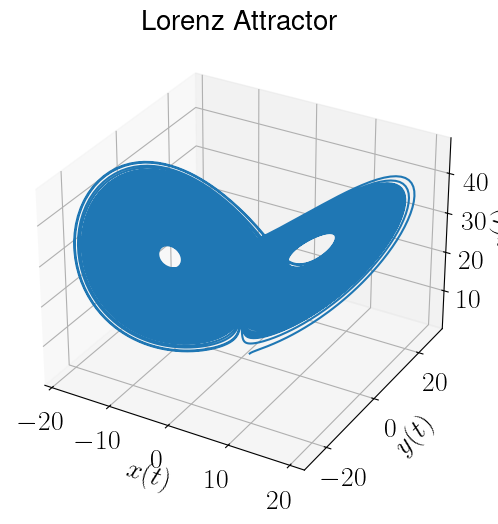

In [7]:
x0 = [1,1,1]
dt = 0.005
rm_transient = 10000
n_train = 100000
n_test = 60000
x,y,z,t = evolve(lorenz,(rm_transient+n_train+n_test+2)*dt,dt,x0)
X = np.vstack((x,y,z)).T
print(X.shape)


n = len(t)

fontsize = 20

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(X[:,0], X[:,1], X[:,2])
ax1.set_xlabel(r'$x(t)$', fontsize=20, rotation=0)
ax1.set_ylabel(r'$y(t)$',fontsize=20)
ax1.set_zlabel(r'$z(t)$', fontsize=20, rotation=60)
ax1.set_title('Lorenz Attractor',fontsize=20)
plt.show()

In [12]:
%config InlineBackend.print_figure_kwargs = {'pad_inches': .5}

In [42]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [53]:
t.shape

(170002,)

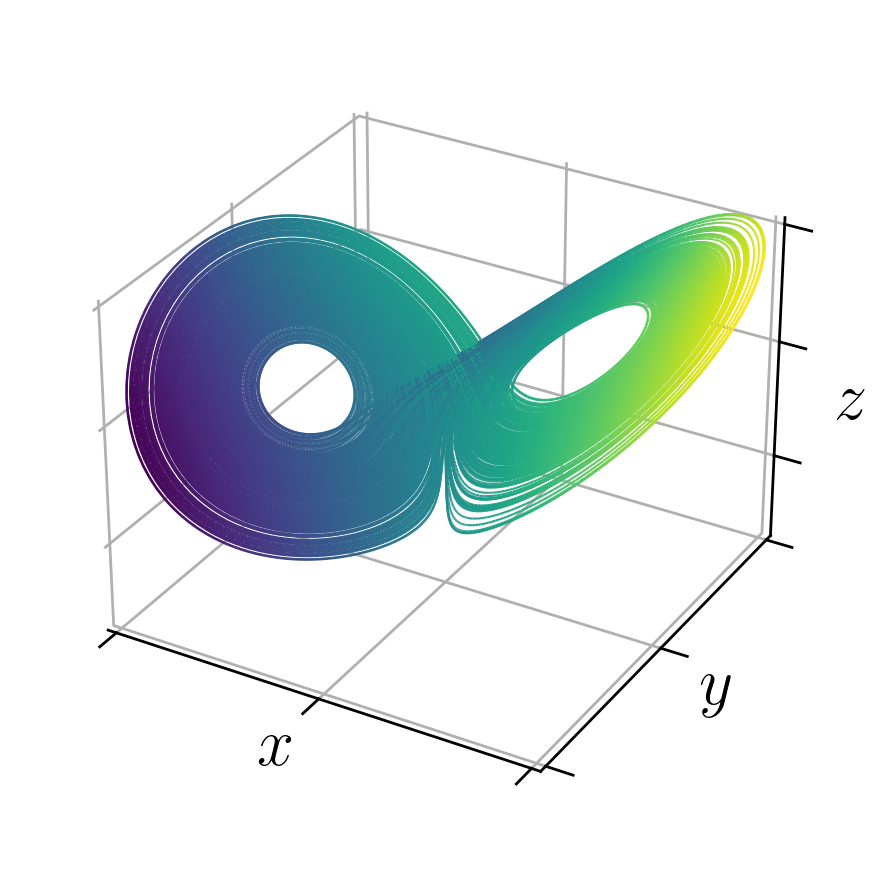

In [71]:
fontsize = 48
labelpad = 5

stride = 1

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(1, 1, 1, projection='3d')

pts = y_test[::stride].reshape(-1,1,3)
segs = np.concatenate([pts[:-1],pts[1:]], axis=1)
lc = Line3DCollection(segs, cmap=mpl.cm.viridis, rasterized=True)
lc.set_array(pts[:,0,1])
# lc.set_array(np.arange(len(pts)))
ax1.add_collection3d(lc)

# ax1.plot(x[rm_transient:],y[rm_transient:],z[rm_transient:],'k',lw=2)
# ax1.scatter(y_test[::stride,0],y_test[::stride,1],y_test[::stride,2],'k',lw=1)



# xticks = ax1.get_xticks()
# print(xticks)
xticks = [-20,0,20]
ax1.set_xticks(xticks)
ax1.set_xticklabels(['' for xtick in xticks], verticalalignment='top', horizontalalignment='right')
# ax1.set_xticklabels(['{:d}'.format(xtick) for xtick in xticks], verticalalignment='top', horizontalalignment='right')
# yticks = ax1.get_yticks()
yticks = [-20,0,20]
ax1.set_yticks(yticks)
ax1.set_yticklabels(['' for ytick in yticks], verticalalignment='center', horizontalalignment='left')
# ax1.set_yticklabels(['{:d}'.format(ytick) for ytick in yticks], verticalalignment='center', horizontalalignment='left')
# zticks = ax1.get_yticks()
zticks = [10,25,40]
ax1.set_zticks(zticks)
ax1.set_zticklabels(['' for ztick in zticks], verticalalignment='top', horizontalalignment='left')
# ax1.set_zticklabels(['{:d}'.format(ztick) for ztick in zticks], verticalalignment='top', horizontalalignment='left')


ax1.set_xlabel(r'$x$', fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='right', labelpad=labelpad)
ax1.xaxis._axinfo['label'].update({'va':'center','ha':'right'})
ax1.set_ylabel(r'$y$', fontsize=fontsize, rotation=0, verticalalignment='bottom', horizontalalignment='left', labelpad=labelpad)
ax1.yaxis._axinfo['label'].update({'va':'center','ha':'left'})
ax1.set_zlabel(r'$z$', fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='center', labelpad=labelpad)
ax1.zaxis._axinfo['label'].update({'va':'top','ha':'left'})
# ax1.set_title('True Attractor',fontsize=fontsize)
# ax1.xaxis.labelpad = labelpad+10
# ax1.yaxis.labelpad = labelpad
# ax1.zaxis.labelpad = labelpad


# plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0)
# fig.align_labels([ax1,ax2])


for axis in [ax1]:
    axis.set_box_aspect(aspect=None, zoom=1)
    for axis1 in [axis.xaxis, axis.yaxis, axis.zaxis]:
        axis1.line.set_linewidth(2)
        axis1.set_pane_color((1.0, 1.0, 1.0, 1.0))
    for axis1 in [axis.xaxis, axis.yaxis, axis.zaxis]:
        axis1._axinfo['tick'].update({'inward_factor':0.75,'outward_factor':0,'linewidth':{True:2.0,False:0.6}})
        axis1._axinfo['grid'].update({'linewidth':2})

ax1.tick_params(axis='y', which='major', pad=15)
ax1.tick_params(axis='z', which='major', pad=10)

# plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)
# ax1.tick_params(length=15,width=3)
# ax2.tick_params(length=15,width=3)


title = 'Example_Lorenz_Attractor'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.5, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.5, dpi=300)
plt.savefig(fig_dir+title+'.svg',bbox_inches='tight',pad_inches=0.5, dpi=300)

plt.show()

In [9]:
LE_max = 0.8739

X_train, y_train = lead_data(X[rm_transient:rm_transient+n_train+1,:])
X_test, y_test = lead_data(X[rm_transient+n_train+1:,:])
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(100000, 3) (60000, 3)
(100000, 3) (60000, 3)


# TreeDOX

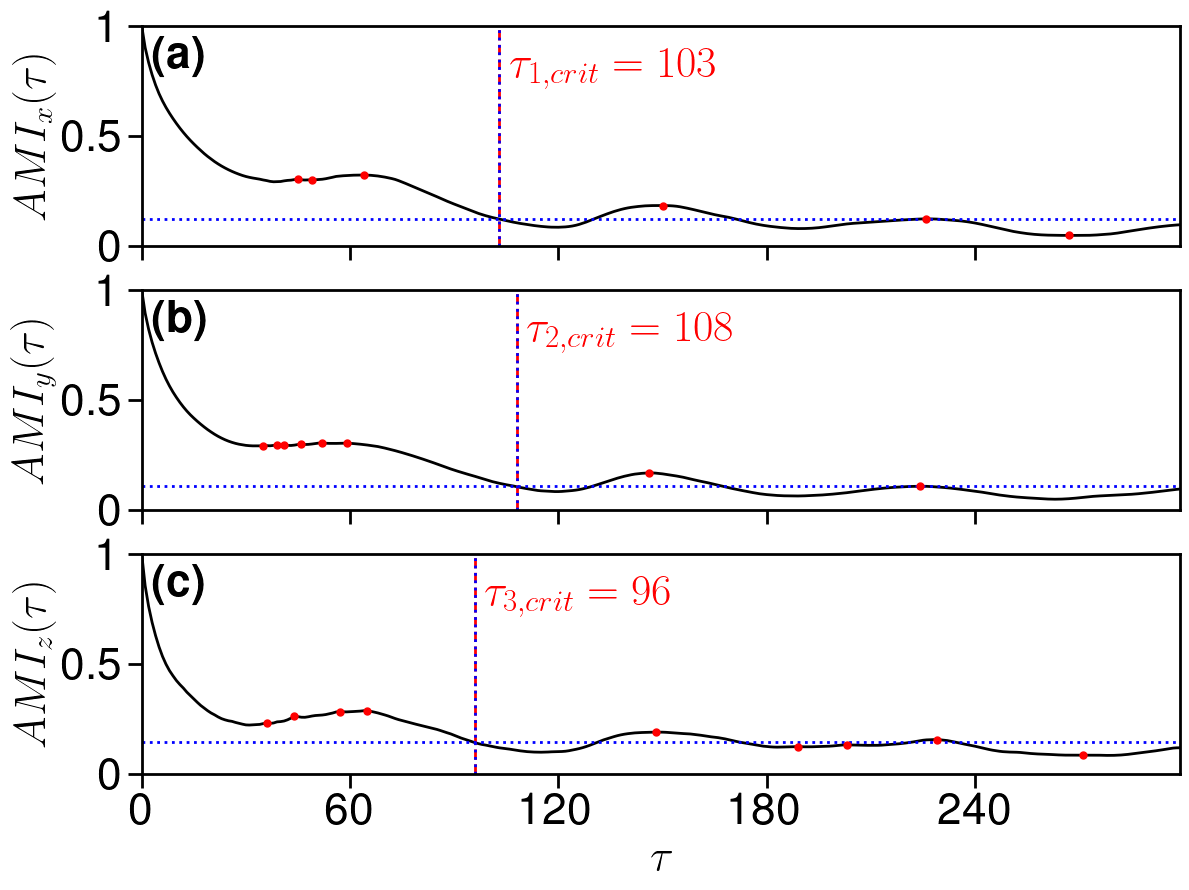

In [25]:
tau_crits = get_tau_crits(X_train, p_val=0.5, max_lag=300, make_plot=True)

In [26]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=1)
print(features.shape, labels.shape)

xi = 1, k = 109
(99891, 327) (99891, 3)


In [27]:
max_depth = None
FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=100,
                                            max_depth=max_depth, random_state=None,
                                            n_jobs=-1, n_samples=None, model_type='ETR',
                                            verbose=True, return_model=True)
all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.9s finished


Training time: 00 hours, 00 minutes, 24.023549 seconds
RAM Used: 1.5G


In [28]:
pvalue_thresh = 0.05
pop_mean = np.median(FIs)
ttest_results = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater')
pvalues = ttest_results.pvalue
CIs = ttest_results.confidence_interval(1-pvalue_thresh)

inds = np.where(pvalues <= pvalue_thresh)[0]

FI_0 = np.min(FIs[inds])
inds = np.where(FIs >= FI_0)[0]
print(len(inds), FI_0)

136 0.0005412444818606556


[]

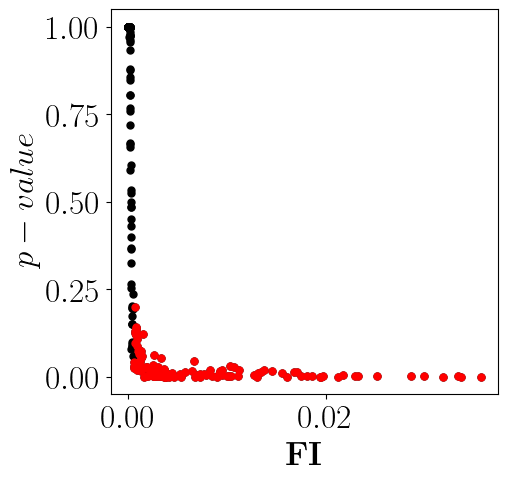

In [29]:
fontsize = 24

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(figsize=(5,5))

ax.plot(FIs, pvalues, 'k.', ms=10)


ax.plot(FIs[inds], pvalues[inds], 'r.', ms=10)
# ax.axvline(pop_mean, c='k', ls='--', lw=2)


ax.set_xlabel(r'$\mathbf{FI}$', fontsize=fontsize)
ax.set_ylabel(r'$p-value$', fontsize=fontsize)

plt.plot()

[]

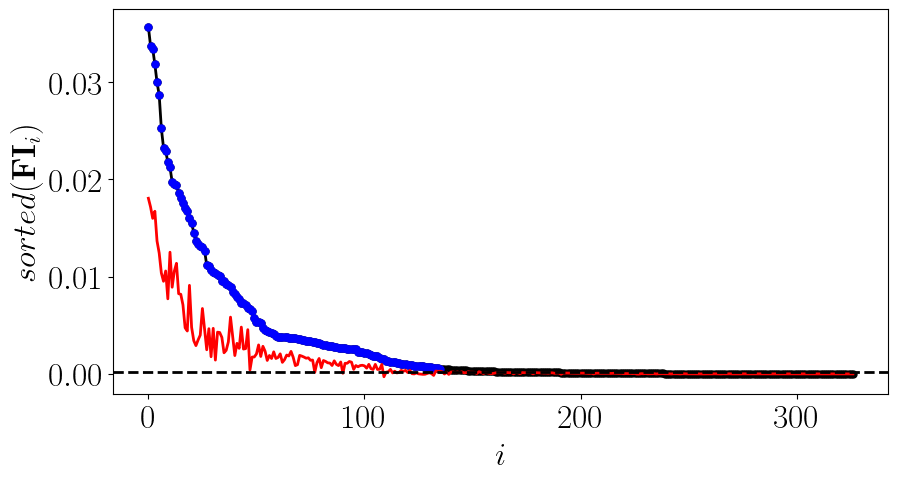

In [30]:
fontsize = 24

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(figsize=(10,5))

sorted_inds = np.argsort(FIs)[::-1]
ax.plot(FIs[sorted_inds], 'k.-', lw=2, ms=10)

where_selected_inds = [np.where(sorted_inds == inds[i])[0][0] for i in range(len(inds))]
ax.plot(where_selected_inds, FIs[inds], 'b.', ms=10)
ax.plot(CIs.low[sorted_inds], 'r-' ,lw=2)
ax.plot(CIs.high[sorted_inds], 'r-' ,lw=2)

ax.axhline(pop_mean,c='k',ls='--',lw=2)

ax.set_xlabel(r'$i$', fontsize=fontsize)
ax.set_ylabel(r'$sorted(\mathbf{FI}_i)$', fontsize=fontsize)

plt.plot()

In [31]:
print(len(inds))

136


In [32]:
len(np.where(FIs>=np.median(FIs))[0])

164

Num features selected (given mean FIs): 136 of 327


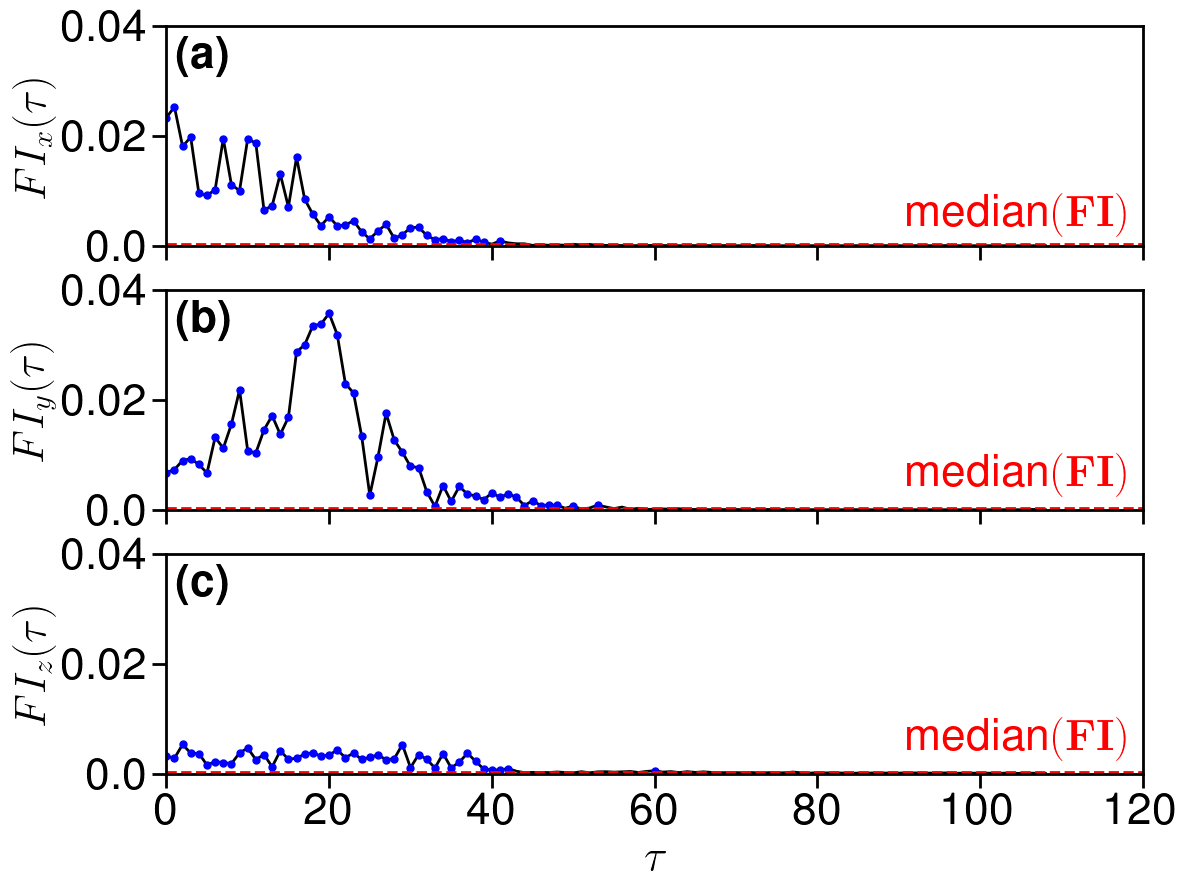

Training time: 00 hours, 00 minutes, 16.456772 seconds
RAM Used: 3.0G


  0%|          | 0/60000 [00:00<?, ?it/s]

Total time: 00 hours, 11 minutes, 06.203343 seconds


In [33]:
y_pred_TreeDOX, model, time_elapsed = future_prediction(features, labels, all_FIs,
                                                        len(y_test), p=None, xi=xi,
                                                        n_estimators=200,
                                                        disp_progress=True,
                                                        desc='',
                                                        max_depth=None,
                                                        random_state=None,
                                                        n_jobs=-1,
                                                        min_samples_split=2,
                                                        min_samples_leaf=1,
                                                        ccp_alpha=0,
                                                        max_features=1.0,
                                                        n_samples=None,
                                                        model=None, s=None,
                                                        model_type='ETR',
                                                        verbose=False,
                                                        model_conversion=None,
                                                        device='mps',
                                                        debug_plot=True, 
                                                        save_fig=True,
                                                        fname='FIs',
                                                        dim_labels=['x','y','z'])

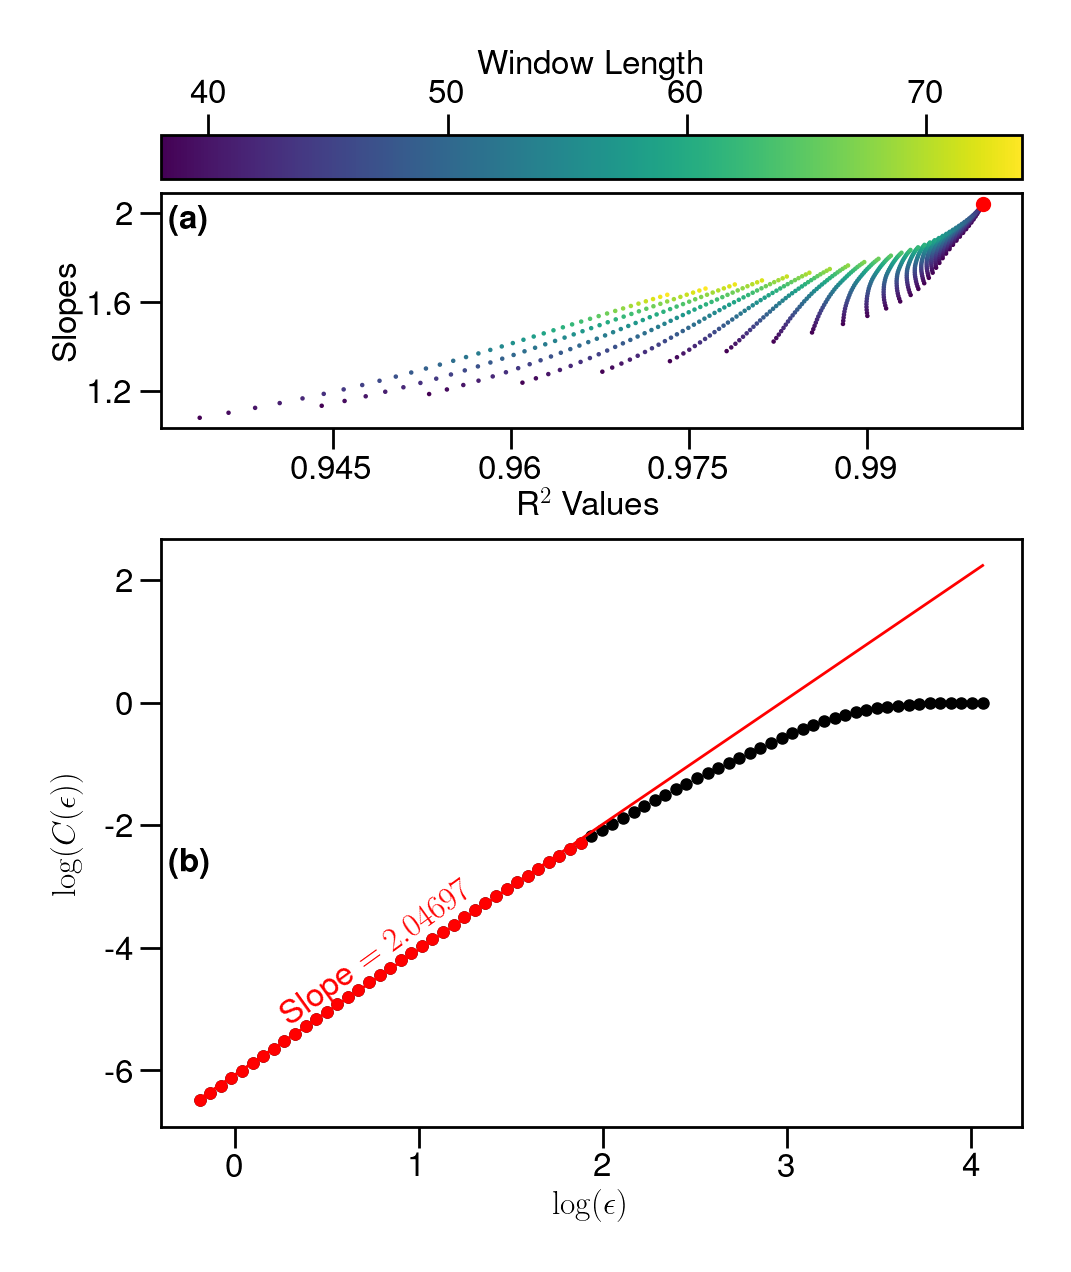

2.0469707962031527


In [39]:
corrdim_test = correlation_dimension(y_test[::10], num=75, lims=None, 
                                     remove_pval=0.45,
                                     mode='highest_r2',
                                     param=0.5, debug_plots=True,
                                     save_fig=True, fname='D2_Lorenz_Test')
print(corrdim_test)

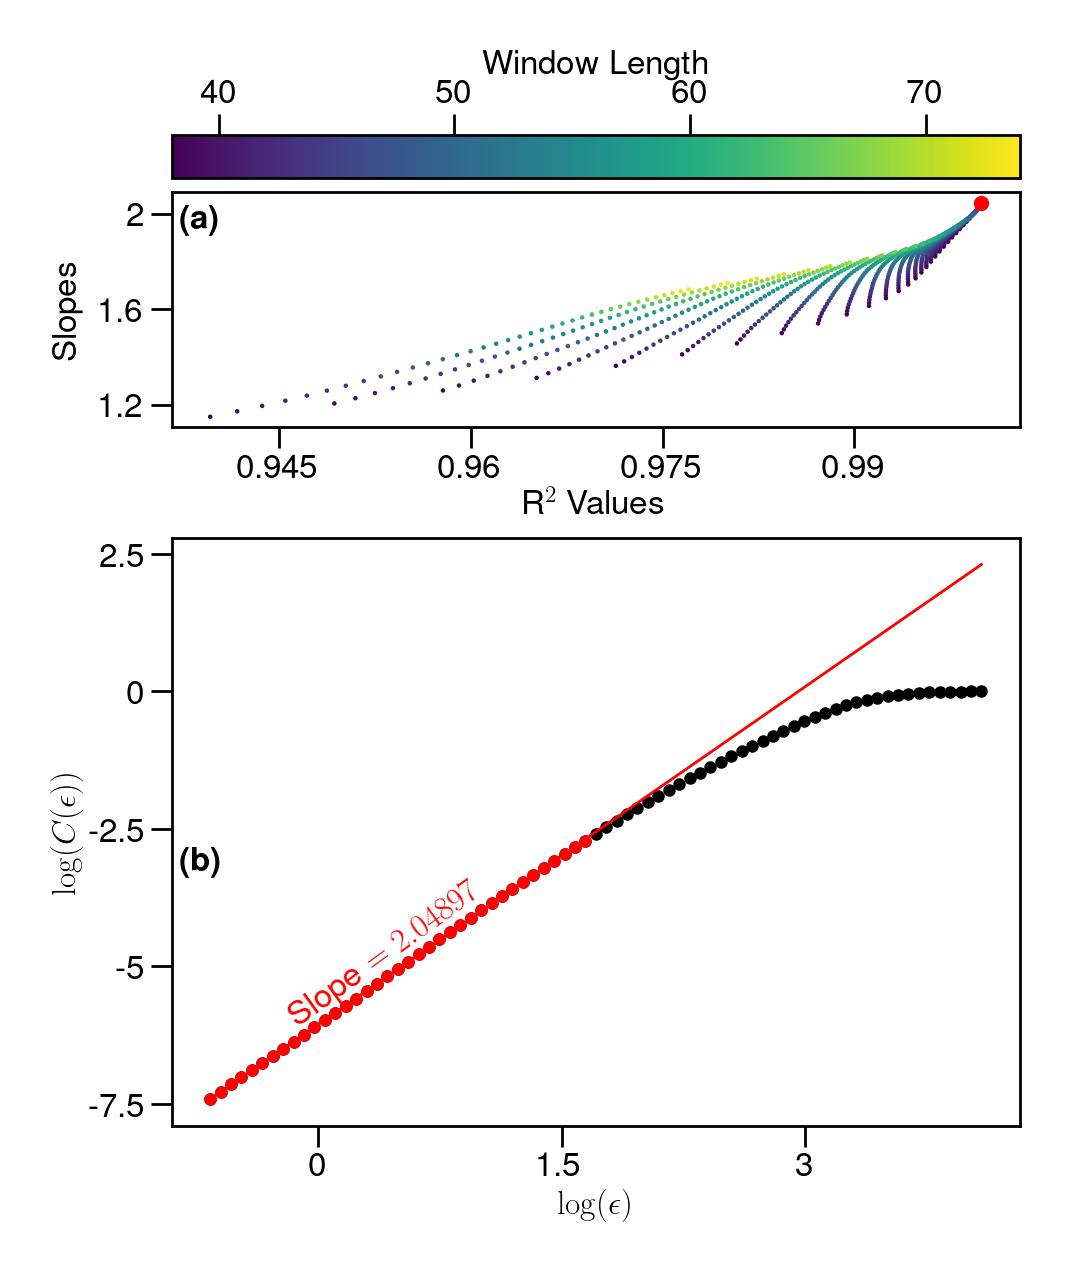

2.048974191538314


In [40]:
corrdim_pred_TreeDOX = correlation_dimension(y_pred_TreeDOX[::10], num=75,
                                             lims=None, remove_pval=0.75,
                                             mode='highest_r2',
                                             param=0.5, debug_plots=True,
                                             save_fig=True, fname='D2_Lorenz_Pred')
print(corrdim_pred_TreeDOX)

In [37]:
%config InlineBackend.print_figure_kwargs = {'pad_inches': .5}

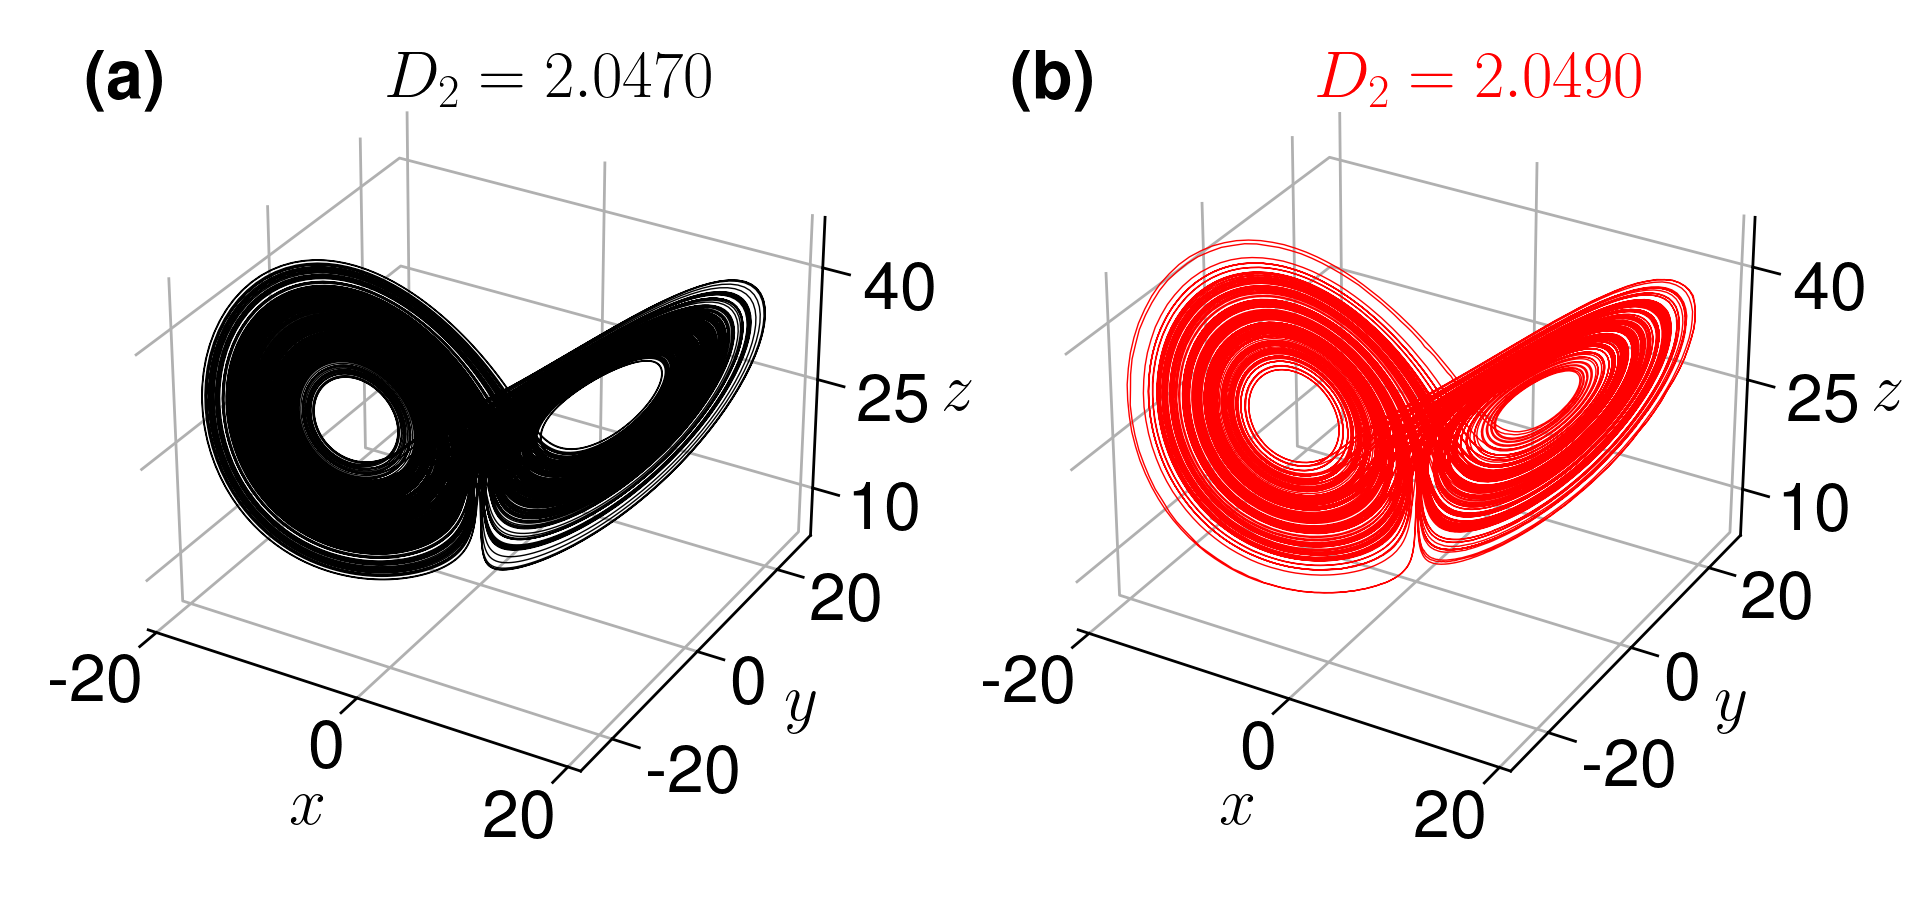

In [38]:
fontsize = 48
labelpad = 35

stride = 1

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(24,10))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')


# ax1.plot(x[rm_transient:],y[rm_transient:],z[rm_transient:],'k',lw=2)
ax1.plot(y_test[::stride,0],y_test[::stride,1],y_test[::stride,2],'k',lw=1)


ax2 = fig.add_subplot(1, 2, 2, projection='3d')


# ax2.plot(x_result,y_result,z_result,'r',lw=2)
ax2.plot(y_pred_TreeDOX[::stride,0],y_pred_TreeDOX[::stride,1],y_pred_TreeDOX[::stride,2],'r',lw=1)



# xticks = ax1.get_xticks()
# print(xticks)
xticks = [-20,0,20]
ax1.set_xticks(xticks)
ax1.set_xticklabels(['{:d}'.format(xtick) for xtick in xticks], verticalalignment='top', horizontalalignment='right')
ax2.set_xticks(xticks)
ax2.set_xticklabels(['{:d}'.format(xtick) for xtick in xticks], verticalalignment='top', horizontalalignment='right')
# yticks = ax1.get_yticks()
yticks = [-20,0,20]
ax1.set_yticks(yticks)
ax1.set_yticklabels(['{:d}'.format(ytick) for ytick in yticks], verticalalignment='center', horizontalalignment='left')
ax2.set_yticks(yticks)
ax2.set_yticklabels(['{:d}'.format(ytick) for ytick in yticks], verticalalignment='center', horizontalalignment='left')
# zticks = ax1.get_yticks()
zticks = [10,25,40]
ax1.set_zticks(zticks)
ax1.set_zticklabels(['{:d}'.format(ztick) for ztick in zticks], verticalalignment='top', horizontalalignment='left')
ax2.set_zticks(zticks)
ax2.set_zticklabels(['{:d}'.format(ztick) for ztick in zticks], verticalalignment='top', horizontalalignment='left')


ax1.set_xlabel(r'$x$', fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='center', labelpad=labelpad)
ax1.set_ylabel(r'$y$',fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', labelpad=labelpad)
ax1.yaxis._axinfo['label'].update({'va':'bottom','ha':'left'})
ax1.set_zlabel(r'$z$', fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='center', labelpad=labelpad)
ax1.zaxis._axinfo['label'].update({'va':'top','ha':'left'})
# ax1.set_title('True Attractor',fontsize=fontsize)
# ax1.xaxis.labelpad = labelpad+10
# ax1.yaxis.labelpad = labelpad
# ax1.zaxis.labelpad = labelpad


ax2.set_xlabel(r'$x$', fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='center', labelpad=labelpad)
ax2.set_ylabel(r'$y$',fontsize=fontsize, verticalalignment='bottom', horizontalalignment='left', labelpad=labelpad)
ax2.yaxis._axinfo['label'].update({'va':'bottom','ha':'left'})
ax2.set_zlabel(r'$z$', fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='center', labelpad=labelpad)
ax2.zaxis._axinfo['label'].update({'va':'top','ha':'left'})
# ax2.set_title('Predicted Attractor',fontsize=fontsize)
# ax2.xaxis.labelpad = labelpad+10
# ax2.yaxis.labelpad = labelpad
# ax2.zaxis.labelpad = labelpad


ax1.annotate(r'\textbf{(a)}', xy=(0.1,1), ha='right', va='top', xycoords="axes fraction", fontsize=fontsize)
ax2.annotate(r'\textbf{(b)}', xy=(0.1,1), ha='right', va='top', xycoords="axes fraction", fontsize=fontsize)
ax1.annotate(r'$D_2={:.4f}$'.format(corrdim_test), xy=(0.6,1), ha='center', va='top', xycoords='axes fraction', fontsize=fontsize)
ax2.annotate(r'$D_2={:.4f}$'.format(corrdim_pred_TreeDOX), xy=(0.6,1), ha='center', va='top', xycoords='axes fraction', fontsize=fontsize, color='r')

# plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0)
# fig.align_labels([ax1,ax2])


for axis in [ax1, ax2]:
    axis.set_box_aspect(aspect=None, zoom=1)
    for axis1 in [axis.xaxis, axis.yaxis, axis.zaxis]:
        axis1.line.set_linewidth(2)
        axis1.set_pane_color((1.0, 1.0, 1.0, 1.0))
    for axis1 in [axis.xaxis, axis.yaxis, axis.zaxis]:
        axis1._axinfo['tick'].update({'inward_factor':0.75,'outward_factor':0,'linewidth':{True:2.0,False:0.6}})
        axis1._axinfo['grid'].update({'linewidth':2})

ax1.tick_params(axis='y', which='major', pad=15)
ax1.tick_params(axis='z', which='major', pad=10)
ax2.tick_params(axis='y', which='major', pad=15)
ax2.tick_params(axis='z', which='major', pad=10)

# plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)
# ax1.tick_params(length=15,width=3)
# ax2.tick_params(length=15,width=3)


title = 'Predicted_Lorenz_Attractor'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.5, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.5, dpi=300)

plt.show()